# DCBC model evaluation

In [2]:
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os

In [3]:
Data = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_atlas_existing_dist-110.tsv', sep='\t')

In [8]:
Data = Data[Data['test_data'] != 'HCP']
Data.head()

,atlas_name,space,K,subj_num,dcbc_group,test_data
0,NettekovenAsym32,MNISymC3,31,0,0.076180,MDTB
1,NettekovenAsym32,MNISymC3,31,1,0.061208,MDTB
2,NettekovenAsym32,MNISymC3,31,2,0.045924,MDTB
3,NettekovenAsym32,MNISymC3,31,3,0.179663,MDTB
4,NettekovenAsym32,MNISymC3,31,4,0.074981,MDTB


<Axes: xlabel='atlas_name', ylabel='dcbc_group'>

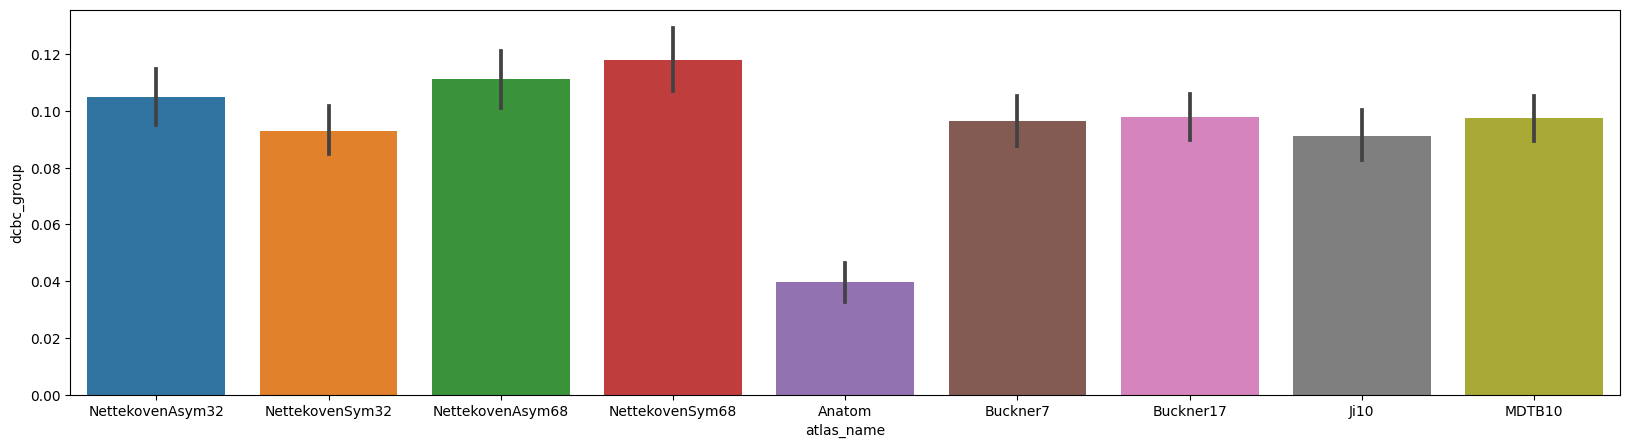

In [12]:
plt.figure(figsize=(20, 5))
sb.barplot(data=Data, x='atlas_name', y='dcbc_group')



<Axes: xlabel='atlas_name', ylabel='dcbc_group'>

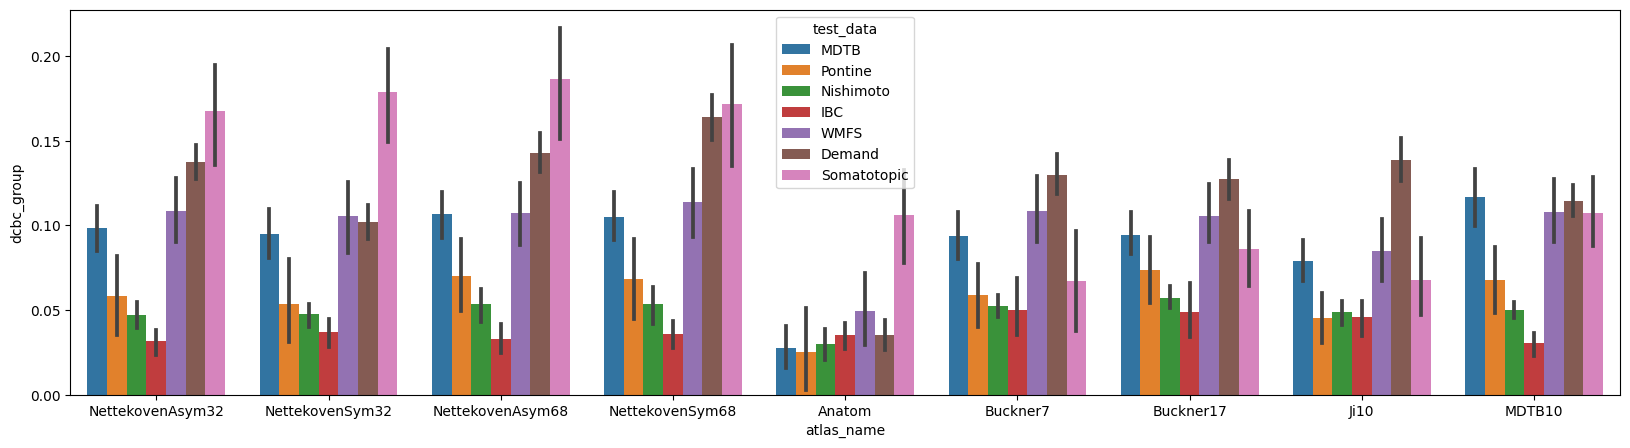

In [11]:
plt.figure(figsize=(20, 5))
sb.barplot(data=Data, x='atlas_name', y='dcbc_group', hue='test_data')

